# Polarity analysis of Fine Food reviews

This dataset consists of a single CSV file, Reviews.csv, and a corresponding SQLite table named Reviews in database.sqlite. The columns in the table are:

This dataset consists of reviews of fine foods. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review. We also have reviews from all other Amazon categories. 

<table>
  <tr>
    <th colspan="2">Dataset Statistics</th>
  </tr>
  <tr>
    <td align="center">Number of reviews</td>
    <td>568,454</td> 
  </tr>
  <tr>
    <td>Number of users</td>
    <td>256,059</td> 
  </tr>
  <tr>
    <td>Number of products</td>
    <td>74,258</td>
  </tr>
  <tr>
    <td>Users with > 50 reviews</td>
    <td>260</td>
  </tr>
  <tr>
    <td>Median no. of words per review</td>
    <td>56</td>
  </tr>
  <tr>
    <td> Timespan</td>
    <td>Oct 1999 - Oct 2012</td>
  <tr>
</table>

There are 10 attributes including Score in the dataset 
1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

Since we want to analyse polarity of each review as "positive" or "negative", we purposefully ignore all Scores equal to "3". If the Score is above 3, then the polarity will be set to "positive". Otherwise, it will be set to "negative". We shall filter all the reviews having Score 3, we consider these reviews as "neutral"

Let's load the dataset and preview few datapoints. 

In [1]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime

In [3]:
# Establising connection to the SQLite database
conn = sqlite3.connect('amazon-fine-food-reviews/database.sqlite')

data = pd.read_sql_query("SELECT * FROM Reviews where Score != 3", conn)
data.shape

(525814, 10)

In [4]:
# Normalizing the Score vector
# If the score is less than 3, then it is Negative review.
# Else it is a positive review.

def normalize_polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Converting the Time vector to readable from UNIX format 
def normalize_time(x):
    date = datetime.fromtimestamp(int(x))
    date = date.strftime('%d-%m-%Y')
    return str(date)

Score = data['Score']
Score = Score.map(normalize_polarity)
data['Score'] = Score

Time = data['Time']
Time = Time.map(normalize_time)
data['Time'] = Time

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,27-04-2011,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,07-09-2012,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,18-08-2008,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,13-06-2011,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,21-10-2012,Great taffy,Great taffy at a great price. There was a wid...


## Removing Duplicates

It is observed that there are some duplicate reviews in the given data. So, it is necessary to remove duplicates in order to get unbiased results for the analysis of data.

** What columns are to be considered for removal of duplicates?**


In [5]:
# Sorting data by ProductId
sorted_data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='heapsort', na_position='last')

In [6]:
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName", "Time", "Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
# Removing reviews which has
# number of users who found the review helpful < number of users who indicated whether they found the review helpful

final = final[final.HelpfulnessNumerator <= final.HelpfulnessNumerator]
final.shape

(364173, 10)

Q1. Please analyse the data, plot the required graphs to show that these conclusions are true
1. Positive reviews are very common.
2. Positive reviews are shorter.
3. Longer reviews are more helpful.
4. Despite being more common and shorter, positive reviews are found more helpful.
5. Frequent reviewers are more discerning in their ratings, write longer reviews, and write more helpful reviews.

In [8]:
pos_data = final[final['Score']=='positive']
neg_data = final[final['Score']=='negative']

In [9]:
print "Number of positive reviews: ",len(pos_data)
print "Number of negative reviews: ",len(neg_data)

Number of positive reviews:  307063
Number of negative reviews:  57110


## Text Preprocessing

Now we need to preprocess the text before analysing it and predicting the model. The steps followed in the text preprocessing are: Our main aim is to find the adjectives which can define the polarity of the reviews. In English literature, it is known that there are no adjectives of length less than or equal to 2. 

1. Tokenization (Removing punctuations, 
    1. White Space tokenizer
    2. Penn Treebank tokenizer
    3. Sentiment-aware tokenizer 
         * Chistopher Potts (HappyFunTokenizer) tokenizer considers all the tokens from NLTK's TweetTokenizer, and add/changes
             * HTML feature tokenization (tags like <\br>)
             * Does not split contractions -- we're, they're, I'd, ...
             * Captures masked curses $#iT -- Shit, F**k, etc
             * Regularizes lengthening (Coooooool--> Coool)
             * Captures multi word expressions --> out of this world, state-of-the-art, etc.
             * Import happyfuntokenizing.py and call tokenize() with a sentence. 
2. Removal of stop words (If we use TF-IDF for featurization, we do not need to remove stop words).
3. Case folding
4. Stemming/Lemmatization -- Porter Stemmer/Lancaster Stemmer

In [13]:
import string
import sys
import re
import nltk
from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from __future__ import unicode_literals # To suppress u'' before every string
sys.displayhook()
from nltk.stem import SnowballStemmer

stop = set(stopwords.words('english'))
#lmtzr = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [16]:
# Case folding
# We use lemmatizer as it give lexically accurate head (base) word. 
# Removal of stop words

#import happyfuntokenizing.py as tk
#import nltk
# Initializing the sentiment-aware tokenizer

# tok = Tokenizer(preserve_case = False) 
# tok = word_tokenize()

# We have segregated positive and negative reviews in two different dataframes
# For each review in pos_data, we preprocess the text and save the postive words in a list
# For each review in neg_data, we preprocess the text and save the negative words in a list
all_pos_words = []
all_neg_words = []
sentences = []
i = 0
for sentence in final['Text'].values:
    filtered_sentence = []
    sentence = BeautifulSoup(sentence, "html5lib").get_text()  # Removing HTML tags
    sentence = re.sub(r"[0-9_/\W]+", " ", sentence)   #Remove all digits,punctuation,special characters,spaces
    #sentence = re.sub('\W+', ' ', sentence)          
    tokens = word_tokenize(sentence)                # Tokenization and casefolding 
    tokens = [stemmer.stem(word.lower()) for word in tokens]  # Snowball Stemmer instead of lemmatizer
    #tokens = [lmtzr.lemmatize(word.lower(),'v') for word in tokens]    # Lemmatization
    if (final['Score'].values)[i] == 'positive':
        for word in tokens:
            # Removal of stop words and the words of length less than 2
            if word not in stop and len(word) > 2:
                all_pos_words.append(word.encode('utf-8', "ignore"))
                filtered_sentence.append(word.encode('utf-8', "ignore"))
    else:sudo apt-get autoclean
        for word in tokens:
            # Removal of stop words and the words of length less than 2
            if word not in stop and len(word) > 2:
                all_neg_words.append(word.encode('utf-8', "ignore"))
                filtered_sentence.append(word.encode('utf-8', "ignore"))
    sentences.append(filtered_sentence)
    i+=1
print len(all_pos_words)
print len(all_neg_words)
print len(sentences)
#[lmtzr.lemmatize(word,'v') for word in l]

11806496
2383262
364173


In [19]:
print "The total  number of tokens appeared in positive reviews : ",len(all_pos_words)
print "The total  number of tokens appeared in negative reviews : ",len(all_neg_words)

The total  number of tokens appeared in positive reviews :  11806496
The total  number of tokens appeared in negative reviews :  2383262


In [20]:
# Now we shall count the frequency of each word in all_pos_words and all_neg_words
all_pos_freq = nltk.FreqDist(all_pos_words)
all_neg_freq = nltk.FreqDist(all_neg_words)
print "5 Most common positive words :", all_pos_freq.most_common(5)
print "5 Most common negative words :", all_neg_freq.most_common(5)

5 Most common positive words : [('like', 140956), ('tast', 131058), ('good', 113687), ('flavor', 111425), ('love', 107658)]
5 Most common negative words : [('tast', 35136), ('like', 32771), ('product', 28651), ('one', 20766), ('flavor', 19981)]


In [21]:
unique_pos_words = list(set(all_pos_words))
unique_neg_words = list(set(all_neg_words))
all_words = unique_pos_words + unique_neg_words
unique_words = set(all_words)
print "Total number of unique positive words is :", len(unique_pos_words)
print "Total number of unique negative words is :", len(unique_neg_words)
print "Total number of unique words in the reviews is :", len(unique_words)

Total number of unique positive words is : 78593
Total number of unique negative words is : 32684
Total number of unique words in the reviews is : 88020


Now we can see that there are around 88K unique words in around 350K reviews. We need to featurize the textual words into some form on which we can apply the machine learning algorithms. 

For featurizing the words to digits, we can use:
1. Bag of words model
    1. Binary vectors
    2. Frequency count vector
2. word2vec
    1. Takes a set of sentences as input and produces word embeddings
3. tf-idf

In [180]:
# Saving the unique_words in a file
import pickle

with open('unique_pos_words', 'wb') as fp:
    pickle.dump(unique_pos_words, fp)

with open('unique_neg_words', 'wb') as fp1:
    pickle.dump(unique_neg_words, fp1)

In [181]:
fp.close()
fp1.close()

In [177]:
with open ('unique_pos_words', 'rb') as fp:
    unique_pos_words = pickle.load(fp)

with open ('unique_neg_words', 'rb') as fp1:
    unique_neg_words = pickle.load(fp1)


Before training the model, partition the dataset into train and test data.

In [128]:
final_clean = final
final_clean['Clean_text'] = sentences # Appending a new column "Clean_text" to the final DataFrame

In [129]:
final_clean.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Clean_text
138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,positive,21-08-2011,Chicken soup with Rice,It's a great book with adorable illustrations....,"[great, book, ador, illustr, true, classic, ki..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,26-12-2001,It Was a favorite!,This was a favorite book of mine when I was a ...,"[favorit, book, mine, littl, girl, would, read..."
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,positive,23-09-2012,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,"[titl, chicken, soup, riceauthor, mauric, send..."
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,positive,05-01-2012,A classic,I remembered this book from my childhood and g...,"[rememb, book, childhood, got, kid, good, reme..."
138697,150515,0006641040,A2RTT81R6Y3R7X,Lindylu,0,0,positive,19-04-2011,One of our family's favorite books,This book is a family favorite and was read to...,"[book, famili, favorit, read, children, small,..."


In [170]:
# Dividing the text as train and test data
# Taking out the top 70% of the data as train_set and rest as test_set

train_set = final.iloc[:int(0.7*len(final)),[0, 8, 9, 10]]#'Text','Summary','Clean_text','Score')]
train_label = final.iloc[:int(0.7*len(final)), [6]]

test_set = final.iloc[int(0.7*len(final)):,[0, 8, 9, 10]]
test_label = final.iloc[int(0.7*len(final)):, [6]]

Now we have got the training and test datasets, we featurize the clean_text words in training dataset. Word2Vec does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The famous example is that, with highly trained word vectors, "king - man + woman = queen." 

We segregate the sentences from train_set and test_set 

In [173]:
print len(sentences[:int(0.7*len(final))])
print len(sentences[int(0.7*len(final)):])

254921
109252


In [174]:
# Training a word2vec model
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                  

In [180]:
from gensim.models import word2vec
print "Training model..."
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_1000minwords_10context"
model.save(model_name)

2017-08-26 15:26:44,673 : INFO : collecting all words and their counts
2017-08-26 15:26:44,675 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-08-26 15:26:44,844 : INFO : PROGRESS: at sentence #10000, processed 406458 words, keeping 15137 word types


Training model...


2017-08-26 15:26:45,005 : INFO : PROGRESS: at sentence #20000, processed 792835 words, keeping 21235 word types
2017-08-26 15:26:45,153 : INFO : PROGRESS: at sentence #30000, processed 1185164 words, keeping 25383 word types
2017-08-26 15:26:45,291 : INFO : PROGRESS: at sentence #40000, processed 1562241 words, keeping 28469 word types
2017-08-26 15:26:45,432 : INFO : PROGRESS: at sentence #50000, processed 1932614 words, keeping 31015 word types
2017-08-26 15:26:45,572 : INFO : PROGRESS: at sentence #60000, processed 2283037 words, keeping 33361 word types
2017-08-26 15:26:45,724 : INFO : PROGRESS: at sentence #70000, processed 2668751 words, keeping 35886 word types
2017-08-26 15:26:45,856 : INFO : PROGRESS: at sentence #80000, processed 3026757 words, keeping 38071 word types
2017-08-26 15:26:45,984 : INFO : PROGRESS: at sentence #90000, processed 3367232 words, keeping 40281 word types
2017-08-26 15:26:46,127 : INFO : PROGRESS: at sentence #100000, processed 3747102 words, keeping 

2017-08-26 15:27:27,853 : INFO : PROGRESS: at 12.60% examples, 226767 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:28,860 : INFO : PROGRESS: at 13.05% examples, 228058 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:29,863 : INFO : PROGRESS: at 13.45% examples, 229256 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:30,916 : INFO : PROGRESS: at 13.87% examples, 230363 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:31,939 : INFO : PROGRESS: at 14.33% examples, 231562 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:32,987 : INFO : PROGRESS: at 14.81% examples, 232541 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:34,003 : INFO : PROGRESS: at 15.28% examples, 233666 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:35,060 : INFO : PROGRESS: at 15.74% examples, 234515 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:36,075 : INFO : PROGRESS: at 16.14% examples, 235376 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:27:37,090 : INFO : PROGRESS: at 16.60% examples, 236171 wor

2017-08-26 15:28:50,556 : INFO : PROGRESS: at 39.72% examples, 213780 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:51,575 : INFO : PROGRESS: at 39.92% examples, 213280 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:52,638 : INFO : PROGRESS: at 40.12% examples, 212645 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:53,639 : INFO : PROGRESS: at 40.38% examples, 212191 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:54,651 : INFO : PROGRESS: at 40.63% examples, 211647 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:55,659 : INFO : PROGRESS: at 40.88% examples, 211127 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:56,707 : INFO : PROGRESS: at 41.12% examples, 210624 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:57,712 : INFO : PROGRESS: at 41.38% examples, 210197 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:58,762 : INFO : PROGRESS: at 41.62% examples, 209627 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:28:59,798 : INFO : PROGRESS: at 41.85% examples, 209203 wor

2017-08-26 15:30:15,568 : INFO : PROGRESS: at 56.78% examples, 175817 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:16,689 : INFO : PROGRESS: at 56.94% examples, 175409 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:30:17,707 : INFO : PROGRESS: at 57.09% examples, 175056 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:18,753 : INFO : PROGRESS: at 57.25% examples, 174679 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:19,868 : INFO : PROGRESS: at 57.43% examples, 174291 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:20,976 : INFO : PROGRESS: at 57.56% examples, 173784 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:30:21,984 : INFO : PROGRESS: at 57.70% examples, 173412 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:23,063 : INFO : PROGRESS: at 57.82% examples, 172944 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:24,080 : INFO : PROGRESS: at 58.01% examples, 172654 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:30:25,094 : INFO : PROGRESS: at 58.12% examples, 172289 wor

2017-08-26 15:31:41,556 : INFO : PROGRESS: at 69.75% examples, 151720 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:31:42,626 : INFO : PROGRESS: at 69.96% examples, 151586 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:31:43,652 : INFO : PROGRESS: at 70.15% examples, 151443 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:31:44,785 : INFO : PROGRESS: at 70.35% examples, 151247 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:31:45,934 : INFO : PROGRESS: at 70.52% examples, 151011 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:31:46,937 : INFO : PROGRESS: at 70.73% examples, 150883 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:31:47,937 : INFO : PROGRESS: at 70.89% examples, 150728 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:31:49,097 : INFO : PROGRESS: at 71.07% examples, 150532 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:31:50,065 : INFO : PROGRESS: at 71.18% examples, 150241 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:31:51,077 : INFO : PROGRESS: at 71.27% examples, 149968 wor

2017-08-26 15:33:06,522 : INFO : PROGRESS: at 83.04% examples, 139995 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:33:07,620 : INFO : PROGRESS: at 83.20% examples, 139823 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:33:08,665 : INFO : PROGRESS: at 83.32% examples, 139620 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:33:09,766 : INFO : PROGRESS: at 83.43% examples, 139398 words/s, in_qsize 7, out_qsize 3
2017-08-26 15:33:10,921 : INFO : PROGRESS: at 83.58% examples, 139230 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:33:11,997 : INFO : PROGRESS: at 83.71% examples, 139044 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:33:13,224 : INFO : PROGRESS: at 83.83% examples, 138783 words/s, in_qsize 6, out_qsize 1
2017-08-26 15:33:14,436 : INFO : PROGRESS: at 83.98% examples, 138574 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:33:15,550 : INFO : PROGRESS: at 84.11% examples, 138355 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:33:16,568 : INFO : PROGRESS: at 84.26% examples, 138215 wor

2017-08-26 15:34:32,022 : INFO : PROGRESS: at 96.12% examples, 131368 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:33,083 : INFO : PROGRESS: at 96.26% examples, 131276 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:34,111 : INFO : PROGRESS: at 96.46% examples, 131252 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:35,203 : INFO : PROGRESS: at 96.61% examples, 131112 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:36,239 : INFO : PROGRESS: at 96.74% examples, 130991 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:37,266 : INFO : PROGRESS: at 96.84% examples, 130855 words/s, in_qsize 7, out_qsize 0
2017-08-26 15:34:38,304 : INFO : PROGRESS: at 96.96% examples, 130750 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:39,327 : INFO : PROGRESS: at 97.11% examples, 130692 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:40,354 : INFO : PROGRESS: at 97.23% examples, 130575 words/s, in_qsize 8, out_qsize 0
2017-08-26 15:34:41,418 : INFO : PROGRESS: at 97.35% examples, 130448 wor

In [181]:
model.doesnt_match("man woman child school kid kitchen".split())

u'kitchen'

In [182]:
model.doesnt_match("good bad like one".split())

u'one'

In [185]:
model.most_similar("bad")

[('horribl', 0.6240944862365723),
 ('terribl', 0.6232780814170837),
 ('gross', 0.5789059400558472),
 ('nasti', 0.5590345859527588),
 ('disgust', 0.5295305252075195),
 ('horrid', 0.52089524269104),
 ('foul', 0.5197350978851318),
 ('weird', 0.5058931112289429),
 ('wors', 0.4976487159729004),
 ('yuck', 0.4943099319934845)]

In [186]:
print model.syn1neg.shape
print "Feature vector of the word 'Food' is\n",model['food']

(8523, 300)
Feature vector of the word 'Food' is
[ -1.39354073e-04  -2.62190178e-02   1.13723278e-01   4.14719731e-02
   5.97785600e-02   5.44529362e-03   5.03265709e-02  -4.96117473e-02
  -3.73242870e-02  -3.38950120e-02   1.17874201e-02   2.55004354e-02
  -2.78128739e-02  -1.13007277e-01   9.37902480e-02  -1.08907163e-01
  -4.38244566e-02  -1.01837199e-02  -9.21475887e-03   6.74026599e-03
   2.96012908e-02   8.13033357e-02  -7.32902959e-02  -1.23700619e-01
   2.37608943e-02  -4.48867045e-02   1.76811442e-02  -5.31681851e-02
   5.42811528e-02   6.33866191e-02   3.75116616e-02   1.55793000e-02
   3.59844491e-02  -1.16773896e-01  -5.45966327e-02  -4.00592312e-02
  -7.05440864e-02  -6.06055148e-02  -4.39760042e-03  -6.38230219e-02
   4.54389602e-02   8.10680687e-02  -7.53196180e-02   1.83801856e-02
   2.35074516e-02   1.48817003e-02   1.82869583e-02   1.25229603e-03
  -6.93182275e-02   2.83265729e-02  -5.59384935e-02  -5.30121848e-02
   4.54410799e-02   6.63473606e-02   3.04884650e-02  -

This seems the model is performing pretty well. For the most influential 8.5K words, we have got the word emmbeddings of size 300. Now using these word embeddings, we need to find the feature vectors for the reviews we have. 

### Vector Averaging
One challenge with the fine food dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review. 

**Our aim is that each review is to be represented by a vector of same length. **

In [233]:
# For each cleaned review, check whether the word is in the model or not
# If the word is present, consider its word_embedding and add it to the existing feature vector
# Else, ignore the word 
# The final feature vector is divided by the number of words considered 
# in the review to get the avg. feature vector

# We are finding the feature vectors for both train and test data.
# Once we get both, we can segregate train by indexing from 0 to int(0.7*len(final) for train
# int(0.7*len(final)) to end for test

index2word_set = set(model.wv.index2word)
reviewFeatureVecs = np.zeros((len(final),num_features),dtype="float32")
counter = 0
for review in final['Clean_text'].values:
    # Each review is a set of words
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0
    for word in review:
        if word in index2word_set:
            num_words+=1
            featureVec = np.add(featureVec,model[word])
    if num_words>0:
        featureVec = np.divide(featureVec, num_words)
    reviewFeatureVecs[counter] = featureVec
    counter = counter+1

In [238]:
trainFeatureVec = reviewFeatureVecs[:int(0.7*len(final)),:]
testFeatureVec = reviewFeatureVecs[int(0.7*len(final)):,:]
print "Train dataset shape: ",trainFeatureVec.shape
print "Test dataset shape: ",testFeatureVec.shape

Train dataset shape:  (254921, 300)
Test dataset shape:  (109252, 300)


Now we got the train and test data sets, we now use different classification techniques to predict the 'Score' of test dataset.
We shall do
1. Random Forests

In [240]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 10)

print "Fitting a random forest to labeled training data..."
forest = forest.fit(trainFeatureVec, train_label)

# Test & extract results 
result = forest.predict(testFeatureVec)
# Write the test results 
output = pd.DataFrame( data={"id":test_set['Id'], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [279]:
predicted =  output.iloc[:,1]
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_label, predicted,labels=['positive','negative'])
cm

array([[87385,  3510],
       [ 9634,  8723]])

By definition a confusion matrix C is such that $C_{i, j}$ is equal to the number of observations known to be in group i but predicted to be in group j. Thus in binary classification, the count of true positives is $C_{0,0}$, false positive is $C_{1,0}$, true negatives is $C_{1,1}$ and false negatives is $C_{0,1}$.


In [288]:
TP = float(cm[0][0]) # We predicted 'Positive' and actually 'Positive'
TN = float(cm[1][1]) # We predicted 'Negative' and actually 'Negative'
FP = float(cm[0][1]) # We predicted 'Positive' but actually 'Negative'
FN = float(cm[1][0]) # We predicted 'Negative' but actually 'Positive'

# Precision:  If we predict 'Yes', how often we are correct?
# Precision = TP/(Predicted Yes)
precision_positive = TP/(TP+FP)
precision_negative = TN/(TN+FN)

# Recall: when it is actually yes, how often did we predict yes? 
# Recall = TP/(Actual Yes)
recall_positive = TP/(TP+FN)
recall_negative = TN/(TN+FP)

accuracy = (TP+TN)/(TP+TN+FP+FN)

print 'precision_positive ', precision_positive,'\n', 'precision_negative ',precision_negative
print 'recall_positive ', recall_positive, '\n', 'recall_negative ', recall_negative
print 'Accuracy ', accuracy

precision_positive  0.961384014522 
precision_negative  0.475186577327
recall_positive  0.900699862913 
recall_negative  0.71307120085
Accuracy  0.879690989639


In [300]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, ['positive', 'negative'],
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[87385  3510]
 [ 9634  8723]]


Normalized confusion matrix
[[ 0.96  0.04]
 [ 0.52  0.48]]


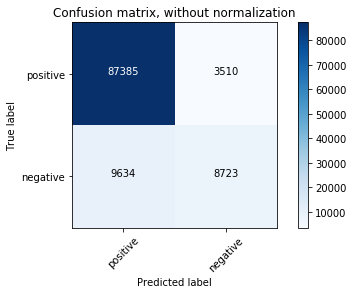

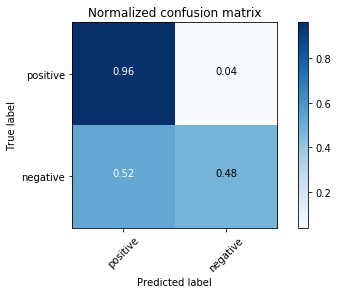

In [301]:
plt.figure()random forest
plot_confusion_matrix(cm, ['positive', 'negative'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Source: 
http://snap.stanford.edu/data/web-FineFoods.html 
https://www.kaggle.com/snap/amazon-fine-food-reviews
